In [1]:
# ! pip install zfit > /dev/null
# ! pip install mplhep > /dev/null

In [2]:
import numpy as np
from math import pi, sin, cos, radians
# Importing sympy to make calculations:
import sympy
import matplotlib.pyplot as plt
import pandas as pd
import time
import sys
from pathlib import Path
from matplotlib._api import check_in_list
import pickle
import tensorflow as tf

2024-02-12 18:00:44.234519: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 18:00:44.907338: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 18:00:44.911216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 18:00:46.520021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Connecting to google drive and importing custom scripts

## Colab connection
# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('drive/MyDrive/colab2021/scripts')

#Local connection

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[1] / "py")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# Importing custom libraries
import plot_tools
import customPDFs

/home/carlos/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [5]:
import zfit

The variables in diferential form are $\cos\theta_K$, $\cos\theta_L$ and $\phi$ have the following ranges



$$-1<\cos\theta_k, \cos\theta_l < 1; \quad 0<\phi<2\pi$$

In [6]:
def transformation(FL, S3, AFB, S9, thetaK, thetaL, phi):
  sum = 9/(16*pi)*(((3/4)*(1-FL)*(sin(thetaK))**2
        + FL*cos(thetaK)**2)
        + (1/4)*(1-FL)*sin(thetaK)**2 * cos(2*thetaL)
        - FL * cos(thetaK)**2 * cos(2*thetaL)
        + S3*sin(thetaK)**2 * sin(thetaL)**2 * cos(2*phi)
        + (4/3) * AFB * sin(thetaK)**2 * cos(thetaL)
        + S9*sin(thetaK)**2 * sin(thetaL)**2 * cos(2*phi) )
  return sum

In [7]:
transformation(1,1,1,1,1,1,1)

0.09063902026138806

Idea:
 - Make an array with a fine mesh of values for all the ranges of $\theta_K$, $\theta_L$ and $\phi$
 - Fix F1 in a value between 1 and 0
 - For a range of values of the $S_3$, $A_{FB}$ and $S_9$ variables, plot only the values that are greater than 1
 - Make 2D plots fixing another variable
 - Design a way to track the values of the parameters and show the relation between them.
  

In [8]:
# Defining the ranges of the variables

x_range = (-1, 1)
y_range = (-1, 1)
z_range = (-1, 1)
phi_range = (0, pi) # changed the range

I want to test every single point in this variable space

# Parameter analysis: Fixing $F_L$ parameter

We asume the $F_L$ parameter to be in the range of $0\leq F_L \leq 1$. We fix this parameter to see how it affects the PDF, making it $F_L=1$ removes the first and third terms, while making it $F_L=0$ removes the second and fourth term

## $F_L = 0$

Integrating must result in a function that evaluated from 0 to 1 in all variables gives a value of 1.

In [9]:
x, y, phi = sympy.symbols('x y phi', real = True)
F_L, S_3, A_FB, S_9 = sympy.symbols('F_L, S_3, A, S_9', real = True, constant = True)

In [10]:
pdf_func = 9/(16*pi)*((3/4)*(1-F_L)*(1-x**2) + F_L*x**2 \
          + (1/4)*(1-F_L)*(1-x**2)*(2*y**2-1) \
          - F_L*x**2*(2*y**2-1) \
          + S_3*(1-x**2)*(1-y**2)*sympy.cos(2*phi) \
          + (4/3)*A_FB*(1-x**2)*y \
          + S_9*(1-x**2)*(1-y**2)*sympy.cos(2*phi) )\

# TO account for the integral, i'd have to substitute sin(theta) -> cos(pi/2 - theta)

In [11]:
integral = sympy.integrate(pdf_func, x, y, phi)

In [12]:
integral


phi*y**2*(-0.0397887357729738*A*x**3 + 0.119366207318922*A*x) + y**3*(-0.0298415518297304*F_L*phi*x**3 - 0.0298415518297304*F_L*phi*x + 0.00994718394324346*S_3*x**3*sin(2*phi) - 0.0298415518297304*S_3*x*sin(2*phi) + 0.00994718394324346*S_9*x**3*sin(2*phi) - 0.0298415518297304*S_9*x*sin(2*phi) - 0.00994718394324346*phi*x**3 + 0.0298415518297304*phi*x) + y*(0.149207759148652*F_L*phi*x**3 - 0.0895246554891911*F_L*phi*x - 0.0298415518297304*S_3*x**3*sin(2*phi) + 0.0895246554891911*S_3*x*sin(2*phi) - 0.0298415518297304*S_9*x**3*sin(2*phi) + 0.0895246554891911*S_9*x*sin(2*phi) - 0.0298415518297304*phi*x**3 + 0.0895246554891911*phi*x)

In [13]:
phi_range = (0,pi)
definite_int = sympy.integrate(pdf_func, (x,x_range[0],x_range[1]), (y,y_range[0],y_range[1]), (phi,phi_range[0],phi_range[1]))

In [14]:
definite_int.evalf()

1.74393424900432e-16*F_L - 3.89817183251938e-17*S_3 - 3.89817183251938e-17*S_9 + 1.0

In [15]:
phi_range = (0,2*pi)
definite_int = sympy.integrate(pdf_func, (x,x_range[0],x_range[1]), (y,y_range[0],y_range[1]), (phi,phi_range[0],phi_range[1]))
definite_int.evalf()

3.48786849800863e-16*F_L - 7.79634366503875e-17*S_3 - 7.79634366503875e-17*S_9 + 2.0

In [16]:
phi_range = (0,pi)

# ZFIT PDF analysis

- Create a parameter space and observable space for the PDF
- Create a custom PDF based on the decayWidth PDF

In [15]:
# Defining the ranges of the variables of the observable space

cosThetaK = zfit.Space('cosThetaK', list(x_range))
cosThetaL = zfit.Space('cosThetaL', list(y_range))
phi = zfit.Space('phi', list(phi_range))
cos2Phi = zfit.Space('cos2Phi', list(z_range))

# Making the tensor product of the observable space

# Creo dos espacios, uno con phi y otro con cos2phi para dos clases de PDF distintas

combined_obs = cosThetaK * cosThetaL * phi
combined_obs2 = cosThetaK * cosThetaL * cos2Phi

In [16]:
combined_obs.obs

('cosThetaK', 'cosThetaL', 'phi')

In [17]:
# Setting the zfit parameters

FL = zfit.Parameter('FL', 0)
AFB = zfit.Parameter('AFB', 0)
S3 = zfit.Parameter('S3', 0)
S9 = zfit.Parameter('S9', 0)

In [18]:
version =  zfit.__version__.split('.')
if int(version[1])>=5:
    from zfit import z
else:
    from zfit import ztf as z

class decayWidth(zfit.pdf.BasePDF):
    '''
    Decay B^0 -> K^{*0} \mu^+ \mu^-
    Funciona directamente con el parámetro de phi
    '''
    _PARAMS = ['FL', 'AFB', 'S3', 'S9']

    def __init__(self, FL, AFB, S3, S9, obs, name="angular_dist" ):
        # se debe definir los parametros a pasar a la pdf
        params = {
              'FL': FL,
              'AFB': AFB,
              'S3': S3,
              'S9': S9}
        super().__init__(obs, params, name=name )#FL=FL, AFB=AFB, S3=S3, S9=S9) # params


    def _unnormalized_pdf(self, x):
        cosThetaK, cosThetaL, phi = z.unstack_x(x)

        #cos2phi = tf.math.cos(2*phi)

        FL = self.params['FL']
        AFB = self.params['AFB']
        S3 = self.params['S3']
        S9 = self.params['S9']

        cosK2 = cosThetaK*cosThetaK
        cosL2 = cosThetaL*cosThetaL

        pdf = (3/4)*(1-FL)*(1-cosK2)
        pdf += FL*cosK2
        pdf += (1/4)*(1-FL)*(1-cosK2)*(2*cosL2-1)
        pdf += - FL*cosK2*(2*cosL2-1)
        #pdf += tf.math.multiply(S3*(1-cosK2)*(1-cosL2), tf.math.cos(2*phi))
        pdf += S3*(1-cosK2)*(1-cosL2)*tf.math.cos(2*phi) # En Colab esta línea no funciona, creo que tiene que ver con la versión de tf
        #pdf += S3*(1-cosK2)*(1-cosL2)*cos(2*phi) # No funciona pues math.cos o np.cos no devuelven tensores
        pdf += (4/3)*AFB*(1-cosK2)*cosL2
        #pdf += tf.math.multiply(S9*(1-cosK2)*(1-cosL2), tf.math.cos(2*phi))
        pdf += S9*(1-cosK2)*(1-cosL2)*tf.math.cos(2*phi)
        #pdf += S9*(1-cosK2)*(1-cosL2)*cos(2*phi)
        pdf = pdf*9/(16*pi)
        return pdf

In [19]:
class decayWidth2(zfit.pdf.BasePDF):
    '''
    Decay B^0 -> K^{*0} \mu^+ \mu^-
    '''
    _PARAMS = ['FL', 'AFB', 'S3', 'S9']

    def __init__(self, FL, AFB, S3, S9, obs, name="angular_dist" ):
        # se debe definir los parametros a pasar a la pdf
        params = {
              'FL': FL,
              'AFB': AFB,
              'S3': S3,
              'S9': S9}
        super().__init__(obs, params, name=name )#FL=FL, AFB=AFB, S3=S3, S9=S9) # params


    def _unnormalized_pdf(self, x):
        cosThetaK, cosThetaL, cos2Phi = z.unstack_x(x)

        FL = self.params['FL']
        AFB = self.params['AFB']
        S3 = self.params['S3']
        S9 = self.params['S9']

        cosK2 = cosThetaK*cosThetaK
        cosL2 = cosThetaL*cosThetaL

        pdf = (3/4)*(1-FL)*(1-cosK2)
        pdf += FL*cosK2
        pdf += (1/4)*(1-FL)*(1-cosK2)*(2*cosL2-1)
        pdf += - FL*cosK2*(2*cosL2-1)
        # Transformé directamente la variable de phi a cos2Phi
        pdf += S3*(1-cosK2)*(1-cosL2)*cos2Phi
        pdf += (4/3)*AFB*(1-cosK2)*cosL2
        pdf += S9*(1-cosK2)*(1-cosL2)*cos2Phi
        pdf = pdf*9/(16*pi)
        return pdf

In [20]:
decay_rate = decayWidth(FL, AFB, S3, S9, combined_obs) # Crea una PDF del Base PDF de zfit
decay_rate2 = decayWidth2(FL, AFB, S3, S9, combined_obs2) # Crea una PDF del Base PDF de zfit

In [37]:
# Para las gráficas solo me concentro en la variable x = cos(theta_K)

# y = cos(theta_L) y z = cos(2 phi) [o phi] se mantienen fijos

x_np = np.linspace(x_range[0], x_range[1], 100)
#x_np = np.zeros(100)
#y_np = np.linspace(y_range[0], y_range[1], 100)
y_np = np.zeros(100)
#z_np = np.linspace(z_range[0], z_range[1], 100)

# Hago que phi valga pi/4 (fijo) para que en el argumento quede cos(2(pi/4)) = cos(pi/2)=0
phi_np = np.ones(100) * pi/4

#z_np = np.zeros(100)

# Esta función evalua cada entrada de phi_np en cos(2 phi)
z_np = np.vectorize(cos)(phi_np * 2)
print(phi_np[0])
print(z_np[0])








0.7853981633974483
6.123233995736766e-17


In [39]:
print(z_np[50])

6.123233995736766e-17


In [40]:
data_mesh_lst = list(zip(x_np, y_np, phi_np))
data_mesh_lst2 = list(zip(x_np, y_np, z_np))

In [41]:
data_mesh = np.array(data_mesh_lst)# This is not quite a mesh, but we have an ordered set
data_mesh2 = np.array(data_mesh_lst2)# This is not quite a mesh, but we have an ordered set
# Here we sould be able to modify all entries to fix a variable

In [42]:
# Creating the data for the mesh PDF
data = zfit.data.Data.from_numpy(array=data_mesh, obs=combined_obs) # obs is automatically used as limits here.

In [43]:
data.data_range.obs

('cosThetaK', 'cosThetaL', 'phi')

Estimated integral error ( 9.5691213736988241e-06 ) larger than tolerance ( 3e-06 ), which is maybe not enough (but maybe it's also fine). You can (best solution) implement an anatytical integral (see examples in repo) or manually set a higher number on the PDF with 'update_integration_options' and increase the 'max_draws' (or adjust 'tol'). If partial integration is chosen, this can lead to large memory consumption.This is a new warning checking the integral accuracy. It may warns too often as it is Work In Progress. If you have any observation on it, please tell us about it: https://github.com/zfit/zfit/issues/new/chooseTo suppress this warning, use zfit.settings.set_verbosity(-1).
Estimated integral error ( 9.00076557563651e-06 ) larger than tolerance ( 3e-06 ), which is maybe not enough (but maybe it's also fine). You can (best solution) implement an anatytical integral (see examples in repo) or manually set a higher number on the PDF with 'update_integration_options' and increase 

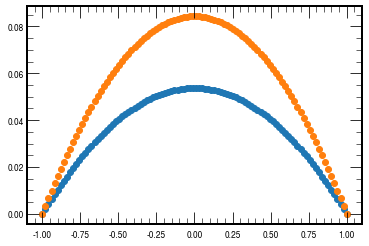

In [44]:
# Identify by hand the possible values that these parameters can have
AFB.set_value(1) # (-1.5, inf) as s3=2 and fl=0 and s9=0, s3=2 played a role in that
FL.set_value(0)
# x solo afecta a FL y AFB, no afecta a s3 y s9
S3.set_value(-1) # Este tampoco, inclusive cambiándolo no cambia la forma, pero es porque y y z son cero
S9.set_value(0) # Este parámetro parece no importar

# La gráfica 1 (azul) muestra la PDF usando phi como parámetro (multiplicación de tensorflow)
# La fráfica 2 (naranja) muestra la PDF usando cos2phi como parámetro

plt.scatter(x_np, decay_rate.pdf(data_mesh))
plt.scatter(x_np, decay_rate2.pdf(data_mesh2))

# Las PDF no resultan ser equivalentes :(